In [1]:
# load autoreload extension
%load_ext autoreload
%autoreload 2

In [2]:
overwrite_model=False
restore_model=True
train_model=False

In [3]:
import os
# os.environ['JAX_PLATFORMS']="cpu"
os.environ['JAX_PLATFORMS']="cuda"


import sys
sys.path.append("./src")

from flax import nnx
import jax 
import jax.numpy as jnp
import optax
from optax.contrib import reduce_on_plateau
import numpy as np

# visualization
import matplotlib.pyplot as plt

from matplotlib import cm

import time
import diffrax

In [4]:
import orbax.checkpoint as ocp
checkpoint_dir = "/lhome/ific/a/aamerio/github/cfm-jax/examples/checkpoints/diffusion_2d_example"

import os
os.makedirs(checkpoint_dir, exist_ok=True)

if overwrite_model:
    checkpoint_dir = ocp.test_utils.erase_and_create_empty(checkpoint_dir)

In [5]:
import jax
import jax.numpy as jnp
from jax import random
from functools import partial

@partial(jax.jit, static_argnums=[1,2,3])  # type: ignore
def make_moons_jax(key, n_samples=100, shuffle=True, noise=None):
    """Make two interleaving half circles using JAX.

    Args:
        n_samples: The total number of points generated.
        shuffle: Whether to shuffle the samples.
        noise: Standard deviation of Gaussian noise added to the data.
        random_state: A JAX random.PRNGKey for reproducibility.

    Returns:
        X: A JAX array of shape (n_samples, 2) containing the generated samples.
        y: A JAX array of shape (n_samples,) containing the integer labels (0 or 1)
           for class membership of each sample.
    """

    n_samples_out = n_samples // 2
    n_samples_in = n_samples - n_samples_out

    # Generate points for the outer moon (label 0)
    outer_circ_t = random.uniform(key, shape=(n_samples_out,)) * jnp.pi
    key, subkey = random.split(key)
    outer_circ_x = jnp.cos(outer_circ_t)
    outer_circ_y = jnp.sin(outer_circ_t)
    X_outer = jnp.vstack([outer_circ_x, outer_circ_y]).T

    # Generate points for the inner moon (label 1)
    inner_circ_t = random.uniform(subkey, shape=(n_samples_in,)) * jnp.pi
    key, subkey = random.split(key)
    inner_circ_x = 1 - jnp.cos(inner_circ_t)
    inner_circ_y = 0.5 - jnp.sin(inner_circ_t)
    X_inner = jnp.vstack([inner_circ_x, inner_circ_y]).T

    # Combine the moons
    X = jnp.vstack([X_outer, X_inner])
    y = jnp.hstack([jnp.zeros(n_samples_out, dtype=jnp.int32), jnp.ones(n_samples_in, dtype=jnp.int32)])

    if noise is not None:
        # Add Gaussian noise
        key, subkey = random.split(key)
        X += random.normal(subkey, shape=X.shape) * noise

    if shuffle:
        # Shuffle the data
        key, subkey = random.split(key)
        permutation = random.permutation(subkey, n_samples)
        X = X[permutation]
        y = y[permutation]

    return X, y



@partial(jax.jit, static_argnums=[1])  # type: ignore
def make_boxes_jax(key, batch_size: int = 200):
    """
    Generates a batch of 2D data points similar to the original PyTorch function
    using JAX.

    Args:
        key: A JAX PRNG key for random number generation.
        batch_size: The number of data points to generate.

    Returns:
        A JAX array of shape (batch_size, 2) with generated data,
        with dtype float32.
    """
    # Split the key for different random operations
    keys = jax.random.split(key, 3)
    x1 = jax.random.uniform(keys[0],batch_size) * 4 - 2
    x2_ = jax.random.uniform(keys[1],batch_size) - jax.random.randint(keys[2], batch_size, 0,2) * 2
    x2 = x2_ + (jnp.floor(x1) % 2)

    data = 1.0 * jnp.concatenate([x1[:, None], x2[:, None]], axis=1) / 0.45
    
    return data

In [6]:
# @partial(jax.jit, static_argnums=[1])  # type: ignore
# def inf_train_gen(key, batch_size: int = 200):
#     x = make_moons_jax(key, batch_size, shuffle=True, noise=0.1)[0]

#     return x

@partial(jax.jit, static_argnums=[1])  # type: ignore
def inf_train_gen(key, batch_size: int = 200):
    x = make_boxes_jax(key, batch_size)

    return x

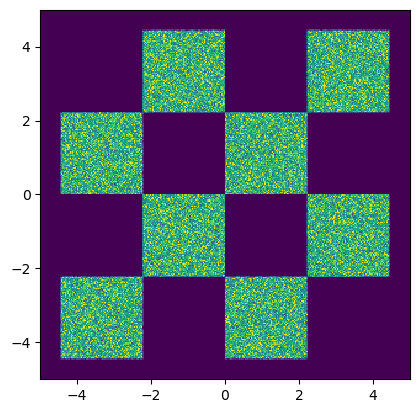

In [7]:
samples = inf_train_gen(jax.random.PRNGKey(0), 500_000)

H=plt.hist2d(samples[:,0], samples[:,1], 300, range=((-5,5), (-5,5)))
cmin = 0.0
cmax = jnp.quantile(jnp.array(H[0]), 0.99).item()
norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

_ = plt.hist2d(samples[:,0], samples[:,1], 300, range=((-5,5), (-5,5)), norm=norm)

# set equal ratio of axes
plt.gca().set_aspect('equal', adjustable='box')


plt.show()

In [8]:
from utils.model_wrapping import ModelWrapper
from diffusion.path import EDMPath
from diffusion.path.scheduler import EDMScheduler
from diffusion.solver import SDESolver

In [9]:
class MLP(nnx.Module):
    def __init__(self, input_dim: int = 2, hidden_dim: int = 128, *, rngs: nnx.Rngs):

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        din = input_dim + 1

        self.linear1 = nnx.Linear(din, self.hidden_dim, rngs=rngs)
        self.linear2 = nnx.Linear(self.hidden_dim, self.hidden_dim, rngs=rngs)
        self.linear3 = nnx.Linear(self.hidden_dim, self.hidden_dim, rngs=rngs)
        self.linear4 = nnx.Linear(self.hidden_dim, self.hidden_dim, rngs=rngs)
        self.linear5 = nnx.Linear(self.hidden_dim, self.input_dim, rngs=rngs)

    def __call__(self, x: jax.Array, t: jax.Array):
        x = jnp.atleast_2d(x)
        t = jnp.atleast_1d(t)
        if len(t.shape)<2:
            t = t[..., None]
            t = jnp.broadcast_to(t, (x.shape[0], t.shape[-1]))
            
        h = jnp.concatenate([x, t], axis=-1)

        x = self.linear1(h)
        x = jax.nn.gelu(x)

        x = self.linear2(x)
        x = jax.nn.gelu(x)

        x = self.linear3(x)
        x = jax.nn.gelu(x)

        x = self.linear4(x)
        x = jax.nn.gelu(x)

        x = self.linear5(x)

        return x

In [10]:
hidden_dim = 512

# velocity field model init
F_model = MLP(input_dim=2, hidden_dim=hidden_dim, rngs=nnx.Rngs(0))

In [11]:
PATIENCE = 10  # @param{type:"integer"}
# @markdown Number of epochs to wait before resuming normal operation after the learning rate reduction:
COOLDOWN = 5  # @param{type:"integer"}
# @markdown Factor by which to reduce the learning rate:
FACTOR = 0.5  # @param{type:"number"}
# @markdown Relative tolerance for measuring the new optimum:
RTOL = 1e-4  # @param{type:"number"}
# @markdown Number of iterations to accumulate an average value:
ACCUMULATION_SIZE = 100
# max LR
MAX_LR = 0.5e-3  # @param{type:"number"}
# Min scale for the learning rate:
MIN_LR = 0  # @param{type:"number"}
MIN_SCALE = MIN_LR / MAX_LR  # @param{type:"number"}

In [12]:
# reduce on plateau schedule
nsteps = 10_000
nepochs = 5

multistep = 1 # if the GPU cannot support batch sizes of at least 4k, adjust this value accordingly to get the desired effective batch size

# warmup_schedule = optax.schedules.warmup_constant_schedule(1e-5, MAX_LR, warmup_steps=1000)

opt = optax.chain(
    optax.adaptive_grad_clip(10.0),
    # optax.adamw(warmup_schedule),
    optax.adamw(MAX_LR),
    reduce_on_plateau(
        patience=PATIENCE,
        cooldown=COOLDOWN,
        factor=FACTOR,
        rtol=RTOL,
        accumulation_size=ACCUMULATION_SIZE,
        min_scale=MIN_SCALE,
    ),
)
if multistep > 1:
    opt = optax.MultiSteps(opt, multistep)
optimizer = nnx.Optimizer(F_model, opt)

In [13]:
# restore the model
if restore_model:
    model_state = nnx.state(F_model)

    with ocp.CheckpointManager(
        checkpoint_dir, options=ocp.CheckpointManagerOptions(read_only=True)
    ) as read_mgr:
        restored = read_mgr.restore(
            1,
            # pass in the model_state to restore the exact same State type
            args=ocp.args.Composite(state=ocp.args.PyTreeRestore(item=model_state))
        )


    abstract_model = MLP(input_dim=2, hidden_dim=hidden_dim, rngs=nnx.Rngs(0))
    graphdef, abstract_state = nnx.split(abstract_model)

    F_model= nnx.merge(graphdef, restored["state"])

ERROR:absl:File /lhome/ific/a/aamerio/github/cfm-jax/examples/checkpoints/diffusion_2d_example/1/metrics/metrics not found.
/lhome/ific/a/aamerio/miniforge3/envs/cfm/lib/python3.12/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1251: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


In [14]:
batch_size = 1024

In [15]:
# instantiate a diffusion path
path = EDMPath(scheduler=EDMScheduler())
loss_fn = path.get_loss_fn() #loss_fn(F, batch, loss_mask=None, *args, **kwargs)

In [ ]:
key = jax.random.PRNGKey(0)
sigma = path.sample_sigma(jax.random.PRNGKey(0), 10)
x_1 = jnp.zeros((10, 2))  # initial points in the 2D space
path_sample = path.sample(key, x_1, sigma)
batch = path_sample.get_batch()
loss_fn(F_model, batch)

Array(3.7700138, dtype=float32)

In [17]:
val_data = inf_train_gen(jax.random.PRNGKey(1), 512)

In [ ]:
@nnx.jit
def val_loss(model, key):
    x_1 = val_data
    sigma = path.sample_sigma(key, x_1.shape[0])
    path_sample = path.sample(key, x_1, sigma)
    batch = path_sample.get_batch()
    
    loss = loss_fn(model, batch)

    return loss

In [19]:
@nnx.jit
def train_step(F_model, optimizer, batch):
    grad_fn = nnx.value_and_grad(loss_fn)
    loss, grads = grad_fn(F_model, batch)
    optimizer.update(grads, value=loss)  # In-place updates.

    return loss

In [20]:
from tqdm import tqdm
early_stopping = True

In [21]:
best_state = nnx.state(F_model)
best_val_loss_value = val_loss(F_model, jax.random.PRNGKey(0))
val_error_ratio = 1.1
counter = 0
cmax = 10
print_every = 100

loss_array = []
val_loss_array = []

rngs = nnx.Rngs(42)

In [ ]:
if train_model:
    F_model.train()

    for ep in range(nepochs):
        pbar = tqdm(range(nsteps))
        l = 0
        v_l = 0
        for j in pbar:
            if counter > cmax and early_stopping:
                print("Early stopping")
                # restore the model state
                graphdef, abstract_state = nnx.split(F_model)

                F_model = nnx.merge(graphdef, best_state)
                break

            x_1 = inf_train_gen(rngs.train_step(), batch_size) # in the context of diffusion models, x0 is the initial data point

            sigma = path.sample_sigma(rngs.train_step(), x_1.shape[0])  # sample noise levels
            path_sample = path.sample(rngs.train_step(), x_1, sigma)
            batch = path_sample.get_batch()

            loss = train_step(F_model, optimizer, batch)  # update model parameters
            l += loss.item()
            
            v_loss = val_loss(F_model, rngs.val_step())
            v_l += v_loss.item()

            if j > 0 and j % 100 == 0:
                loss_ = l / 100
                val_ = v_l / 100

                ratio1 = val_ / loss_
                ratio2 = val_ / best_val_loss_value

                # if ratio1 < val_error_ratio and ratio2 < 1.05:
                if ratio1 < val_error_ratio:
                    if val_ < best_val_loss_value:
                        best_val_loss_value = val_
                        best_state = nnx.state(F_model)
                    elif ratio2 < 1.05:
                        best_state = nnx.state(F_model) # still update the best state if the ratio is below 1.05

                    counter = 0
                else:
                    counter += 1

                pbar.set_postfix(
                    loss=f"{loss_:.4f}",
                    ratio=f"{ratio1:.4f}",
                    counter=counter,
                    val_loss=f"{val_:.4f}",
                )
                loss_array.append(loss_)
                val_loss_array.append(val_)
                l = 0
                v_l = 0

    F_model.eval()



In [23]:
# save the model
if train_model:
    checkpoint_manager = ocp.CheckpointManager(checkpoint_dir,
        options=ocp.CheckpointManagerOptions(
            max_to_keep=2,
            keep_checkpoints_without_metrics=False,
            create=True,
        ),
    )
    model_state = nnx.state(F_model)
    checkpoint_manager.save(
        1, args=ocp.args.Composite(state=ocp.args.PyTreeSave(model_state))
    )

    checkpoint_manager.close()

# sample the model

In [24]:
F_model.eval()

In [25]:
nsteps = 30

norm = cm.colors.Normalize(vmax=50, vmin=0)

nsamples = 100_000  # batch size


key = jax.random.PRNGKey(0)

solver = SDESolver(score_model=F_model, path=path)  # create an SDESolver class
x_init = path.sample_prior(key, (nsamples,2) )  # sample initial points from the prior distribution
samples = solver.sample(key, x_init, nsteps=nsteps, return_intermediates=True)  # sample from the model

In [26]:
nsteps

30

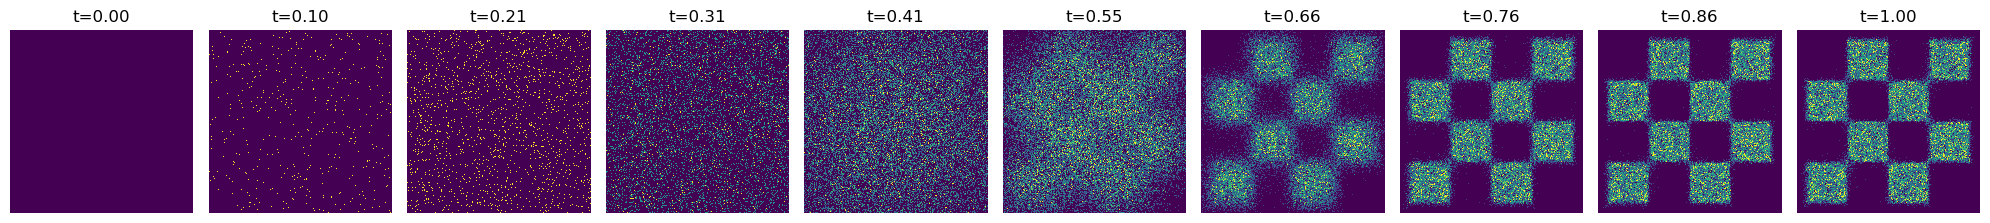

In [27]:
T = np.linspace(0, 29, 10, endpoint=True, dtype=int)  # convert to numpy array

fig, axs = plt.subplots(1, len(T), figsize=(20,20))

for i,step in enumerate(T):
    H = axs[i].hist2d(samples[step,:,0], samples[step,:,1], 300, range=((-5,5), (-5,5)))
    
    cmin = 0.0
    cmax = jnp.quantile(jnp.array(H[0]), 0.99).item()
    
    norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)
    
    _ = axs[i].hist2d(samples[step,:,0], samples[step,:,1], 300, range=((-5,5), (-5,5)), norm=norm)
    
    axs[i].set_aspect('equal')
    axs[i].axis('off')
    axs[i].set_title(f't={step/(nsteps-1):.2f}')
    
plt.tight_layout()
plt.show()

In [28]:
from utils.plotting import plot_trajectories

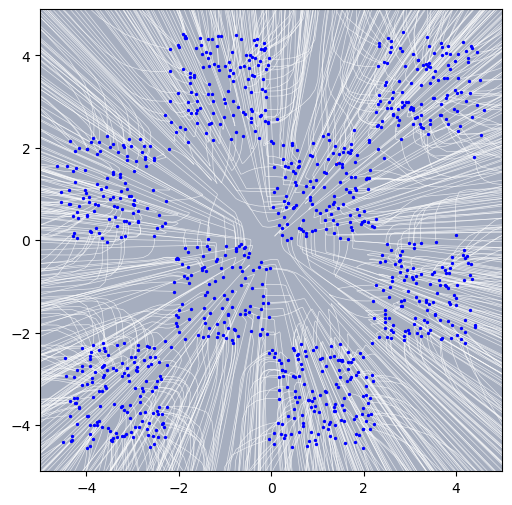

In [31]:
fig, ax = plot_trajectories(samples[:,:1000,:],)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()